### Simulation for an Interview process

The model that I chose to simulate is the interview process in a multinational company. It is not always quick and easy to get hired. The job interview process can be lengthy. Today, many companies have an involved walk-in interview process, starting with registration, screening documents, followed by in-person interviews, second interviews, and even third interviews. I have tried to simulate this process from the time a candidate enters the company till the time he exits the company.

Started with importing the regular libraries and simpy library

In [195]:
#imported required libraries
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy
from pathlib import Path

### Model1 - A simple model

The first model that I have attempted is a simple model in which only candidate arrival process is simulated. This model will be followed by other steps that will add to the complexity of the model.
Generated random number to simulate random arrival of the candidates.

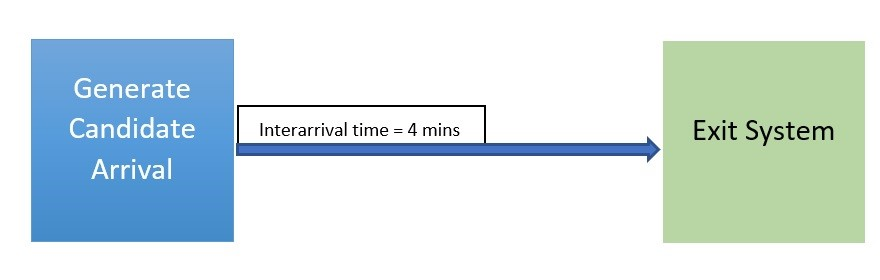

In [196]:
Image("images/candidate_arrival.jpg")

In [197]:
# generate random number using numpy
from numpy.random import default_rng
rg = default_rng(seed=123)
print(rg.random())
print(rg.random())

0.6823518632481435
0.053821018802222675


In [198]:
# Assumed that the arrival time between two candidates is 4 minutes
interarrival_time = 4

In [199]:
# Import exponential distribution function from scipy.stats
from scipy.stats import expon
# Set mean of this distribution to whatever we were using above for interarrival time
mean_interarrival_time = interarrival_time
# Create a random variable object based on the exponential distribution with the given mean
rv_expon = expon(scale=mean_interarrival_time)

Created a function to print the arrival time of candidates with an interarrivaltime of 4 minutes

In [200]:
def candidate_arrivals(env, interarrival_time=0.0,rg=default_rng(0)):
    """Generate candidates according to a fixed time arrival process"""

    # Create a counter to keep track of number of candidates generated and to serve as unique candidate id
    candidate = 0

    # Infinite loop for generating candidates
    while True:

        # Generate next interarrival time 
        iat = rg.exponential(interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New candidate generated = update counter of candidates
        candidate += 1
        
        print(f"Candidate {candidate} created at time {env.now}")

In [201]:
# Initialized a simulation environment
env1 = simpy.Environment()

# Created a process generator and start it and add it to the env

runtime = 25
interarrival_time = 4.0
env1.process(candidate_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

Candidate 1 created at time 2.7197276158756383
Candidate 2 created at time 6.798116021739097
Candidate 3 created at time 6.877342672095319
Candidate 4 created at time 6.886419978820231
Candidate 5 created at time 9.087791469376423
Candidate 6 created at time 15.607553208009964
Candidate 7 created at time 18.30188501867889
Candidate 8 created at time 21.323090449980455


Added different parameters to the model  like adding a resource(interviewer) and adding waiting time to the interview process.

In [202]:
def simplified_int_process(env, name, mean_preint_time, mean_int_time, mean_postint_time, interviewer):
    """Process function modeling how a canididates flows through system."""

    print(f"{name} Entering interview venue at {env.now:.4f}")
    
    # Yield for the pre-int time
    yield env.timeout(rg.exponential(mean_preint_time))
    
    # Request interviewer for interview
    with interviewer.request() as request:
        print(f"{name} Requested interviewer at {env.now:.4f}")
        yield request
        print(f"{name} Got interviewer at {env.now:.4f}")
        yield env.timeout(rg.normal(mean_int_time, 0.5))
                          
    # Yield for the post-int time
    yield env.timeout(mean_postint_time)
    
    # The process is over, we would exit the venue
    print(f"{name} Exiting interview venue at {env.now:.4f}")

In [203]:
def candidate_arrivals_random_2(env, mean_interarrival_time, mean_preint_time, mean_int_time, mean_postint_time, interviewer, rg=default_rng(0)):
    
    """Generate candidates according to a Poisson arrival process"""

    # Create a counter to keep track of number of candidates generated and to serve as unique candidate id
    candidate = 0

    # Infinite loop for generating candidates
    while True:

        # Generate next interarrival time
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of candidates
        candidate += 1

        print(f"Candidate{candidate} created at time {env.now}")
                     
        # Create a new candidate delay process generator object.
        candidate_visit = simplified_int_process(env, 'Candidate{}'.format(candidate), 
                                               mean_preint_time, mean_int_time, mean_postint_time, interviewer)
        
        # Register the process with the simulation environment
        env.process(candidate_visit)

In [204]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Set input values
mean_interarrival_time = 4.0
mean_preint_time = 5.0
mean_int_time = 15.0
mean_postint_time = 15.0
num_interviewers = 5

# Create interviewer resource
interviewer = simpy.Resource(env2, num_interviewers)

# Register our new arrivals process
env2.process(candidate_arrivals_random_2(env2, mean_interarrival_time, mean_preint_time, mean_int_time, mean_postint_time, interviewer))

# Run the simulation
runtime = 50
env2.run(until=runtime)

Candidate1 created at time 2.7197276158756383
Candidate1 Entering interview venue at 2.7197
Candidate1 Requested interviewer at 3.9787
Candidate1 Got interviewer at 3.9787
Candidate2 created at time 6.798116021739097
Candidate2 Entering interview venue at 6.7981
Candidate3 created at time 6.877342672095319
Candidate3 Entering interview venue at 6.8773
Candidate4 created at time 6.886419978820231
Candidate4 Entering interview venue at 6.8864
Candidate2 Requested interviewer at 7.2571
Candidate2 Got interviewer at 7.2571
Candidate5 created at time 9.087791469376423
Candidate5 Entering interview venue at 9.0878
Candidate5 Requested interviewer at 11.5764
Candidate5 Got interviewer at 11.5764
Candidate6 created at time 15.607553208009964
Candidate6 Entering interview venue at 15.6076
Candidate7 created at time 18.30188501867889
Candidate7 Entering interview venue at 18.3019
Candidate3 Requested interviewer at 18.6354
Candidate3 Got interviewer at 18.6354
Candidate6 Requested interviewer at

### Model2 - Full Model

Now I have tried to create a full model with different process, like registration, screening, interview and waiting time after the interview. All these individual processes will also have a waiting time depending on the resources available.

-Candidate arrives to the interview facility

-Then he moves to the registration facility

-Once registration is completed candidate moves to get his documents checked

-After documents check interview will be conducted

-If the candidate clears the interview and needs a next round scheduler will schedule the next interview

-While the results is being communicated the candidate waits in the waiting area.

-Then he / she exits the interview facility

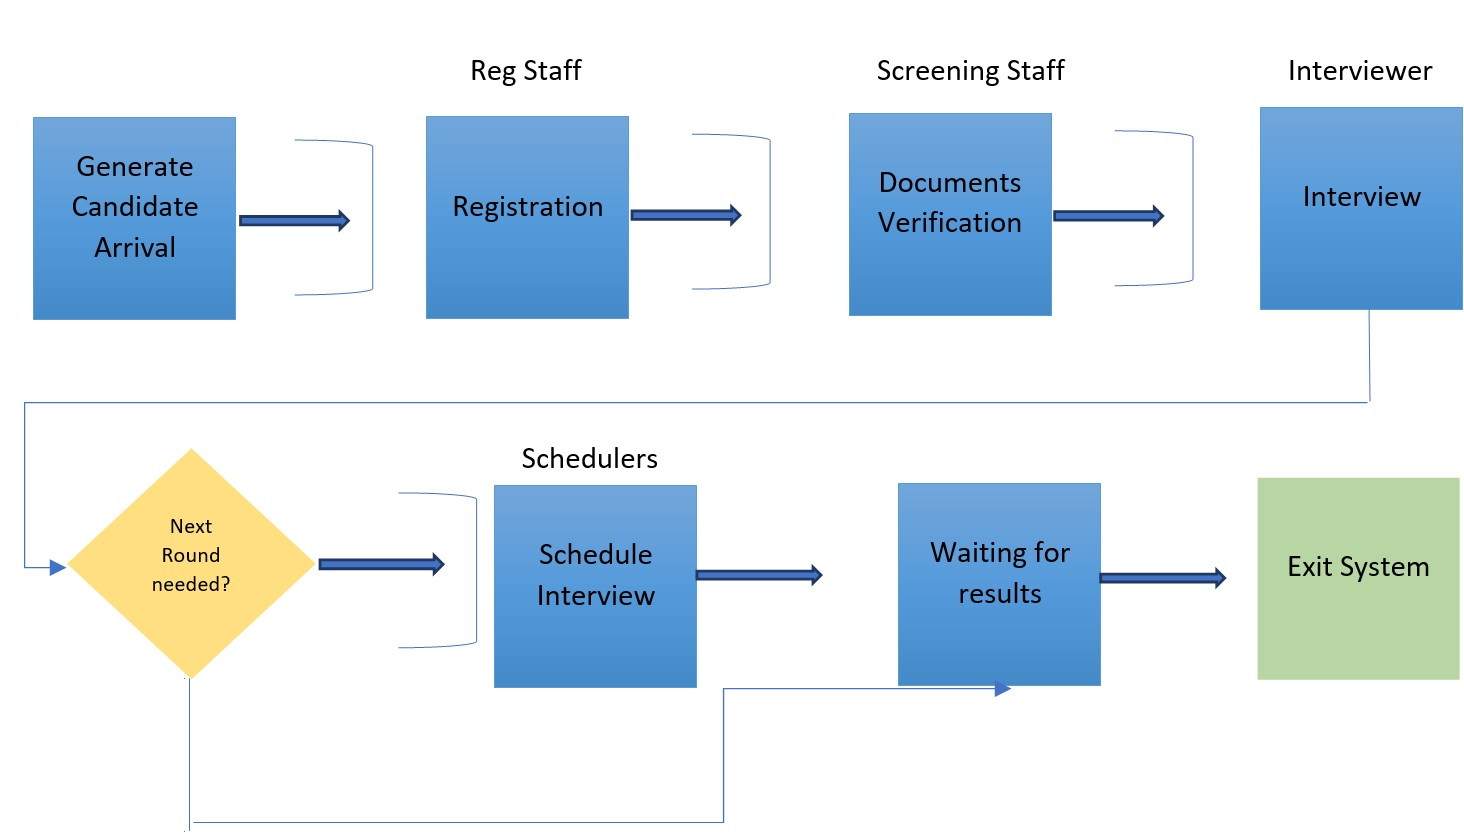

In [205]:
Image("images/full_model.jpg")

In [206]:
class InterviewSessions(object):
    def __init__(self, env, num_reg_staff, num_screening_staff, num_interviewers, num_schedulers, rg):
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # Create list to hold timestamps dictionaries (one per candidate)
        self.timestamps_list = []
        # Create lists to hold occupancy tuples (time, occ)
        self.postint_occupancy_list = [(0.0, 0.0)]
        self.int_occupancy_list = [(0.0, 0.0)]
        
        # Created resources
        self.reg_staff = simpy.Resource(env, num_reg_staff)
        self.screening_staff = simpy.Resource(env, num_screening_staff)
        self.interviewer = simpy.Resource(env, num_interviewers)
        self.scheduler = simpy.Resource(env, num_schedulers)

    # Create process methods
    
    def registration(self, candidate):
        yield self.env.timeout(self.rg.exponential(1.0))
        
    def document_check(self, candidate):
        yield self.env.timeout(self.rg.normal(2, 0.5))

    def interview(self, candidate):
        yield self.env.timeout(self.rg.normal(15.0, 1.0))
        
    def schedule_next_round(self, candidate):
        yield self.env.timeout(self.rg.normal(1.0, 0.25))

    def wait_gt_10(self, candidate):
        yield self.env.timeout(self.rg.exponential(0.5))

Added normal and exponential distributions for time taken to complete each of the process

generator function for the model

In [207]:
def interview_sheduled(env, candidate, interviewprocess, pct_second_round, rg):
    # Candidate arrives to venue - note the arrival time
    arrival_ts = env.now


    # Request reg staff for registration
    with interviewprocess.reg_staff.request() as request:
        yield request
        got_reg_ts = env.now
        yield env.process(interviewprocess.registration(candidate))
        release_reg_ts = env.now
        
        # Request a screening_staff to check documents
    with interviewprocess.screening_staff.request() as request:
        yield request
        # Now that we have a screening_staff, check documents. Note time.
        got_screening_staff_ts = env.now
        yield env.process(interviewprocess.document_check(candidate))
        release_screening_staff_ts = env.now
        
    # Request interviewer to conduct interview
    with interviewprocess.interviewer.request() as request:
        yield request
        got_interviewer_ts = env.now
        
        # Update interview occupancy - increment by 1
        prev_occ = interviewprocess.int_occupancy_list[-1][1]
        new_occ = (env.now, prev_occ + 1)
        interviewprocess.int_occupancy_list.append(new_occ)
        yield env.process(interviewprocess.interview(candidate))
        release_interviewer_ts = env.now

        interviewprocess.int_occupancy_list.append((env.now, interviewprocess.int_occupancy_list[-1][1] - 1))
        
        # Update postint occupancy - increment by 1
        interviewprocess.postint_occupancy_list.append((env.now, interviewprocess.postint_occupancy_list[-1][1] + 1))

    # Request scheduler to schedule next round if needed
    if rg.random() < pct_second_round:
        with interviewprocess.scheduler.request() as request:
            yield request
            got_scheduler_ts = env.now
            yield env.process(interviewprocess.schedule_next_round(candidate))
            release_scheduler_ts = env.now
    else:
        got_scheduler_ts = pd.NA
        release_scheduler_ts = pd.NA
        
    # Wait at least 10 minutes from  the time interview was completed to get  the results
    post_int_time = env.now - release_interviewer_ts
    if post_int_time < 10:
        # Wait until 10 total minutes post int
        yield env.timeout(10 - post_int_time)
        # Wait random amount beyond 10 minutes
        yield env.process(interviewprocess.wait_gt_10(candidate))
        exit_system_ts = env.now
        
        # Update postint occupancy - decrement by 1
        interviewprocess.postint_occupancy_list.append((env.now, interviewprocess.postint_occupancy_list[-1][1] - 1))
    
    exit_system_ts = env.now    
    #print(f"Candidate {candidate} exited at time {env.now}")

    # Create dictionary of timestamps
    timestamps = {'candidate_id': candidate,
                  'arrival_ts': arrival_ts,
                  'got_reg_ts': got_reg_ts,
                  'release_reg_ts': release_reg_ts,
                  'got_screening_staff_ts': got_screening_staff_ts,
                  'release_screening_staff_ts': release_screening_staff_ts,
                  'got_interviewer_ts': got_interviewer_ts,
                  'release_interviewer_ts': release_interviewer_ts,
                  'got_scheduler_ts': got_scheduler_ts,
                  'release_scheduler_ts': release_scheduler_ts,
                  'exit_system_ts': exit_system_ts}
    
    interviewprocess.timestamps_list.append(timestamps)

The function below will run for specific amount of hours (9am to 6pm)

In [208]:
def run_interviewprocess(env, interviewprocess, mean_interarrival_time, pct_second_round, rg, 
               stoptime=simpy.core.Infinity, max_arrivals=simpy.core.Infinity):
      
    # Create a counter to keep track of number of candidates generated and to serve as unique candidate id
    candidate = 0

    # Loop for generating candidate
    while env.now < stoptime and candidate < max_arrivals:

        # Generate next interarrival time 
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New candidate generated = update counter of candidate
        candidate += 1
        
        #print(f"Candidate {candidate} created at time {env.now}")

        env.process(interview_sheduled(env,candidate, interviewprocess, pct_second_round, rg))

Created main function which will store the excel files into the local folder

In [209]:
def main():
    
    # Hard coded candidates arrival rate (candidates per hour)
    candidates_per_hour = 150
    mean_interarrival_time = 1.0 / (candidates_per_hour / 60.0)
    pct_second_round = 0.50  # assuming 50% of the candidates would need a secod round
    
    # Create a random number generator
    rg = default_rng(seed=123)
    
    # Hard coded in the resource capacity levels 
    num_reg_staff = 2
    num_screening_staff = 3
    num_interviewers = 12
    num_schedulers = 2
    
    # Hours of operation
    stoptime = 420 # No more arrivals after this time
    
    # Create a simulation environment
    env = simpy.Environment()
    
    # Create  interviewprocess to simulate
    interviewprocess = InterviewSessions(env, num_reg_staff, num_screening_staff, num_interviewers, num_schedulers, rg)
    
    # Register the run_interviewprocess function
    env.process(run_interviewprocess(env, interviewprocess, mean_interarrival_time, pct_second_round, rg, stoptime=stoptime))
    
    # Run the simulation
    env.run()
    
  
    
    # Output log files . Csv file will be saved into a local folder
    
    interviewproces_candidate_log_df = pd.DataFrame(interviewprocess.timestamps_list)
    interviewproces_candidate_log_df.to_csv('./output/interviewproces_candidate_log_df.csv', index=False)
    
    int_occupancy_df = pd.DataFrame(interviewprocess.int_occupancy_list, columns=['ts', 'occ'])
    int_occupancy_df.to_csv('./output/int_occupancy_df.csv', index=False)
    
    postint_occupancy_df = pd.DataFrame(interviewprocess.postint_occupancy_list, columns=['ts', 'occ'])
    postint_occupancy_df.to_csv('./output/postint_occupancy_df.csv', index=False)
    
    # Note simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)

In [210]:
interview_end_time = main()

Simulation ended at time 1353.5003343373767


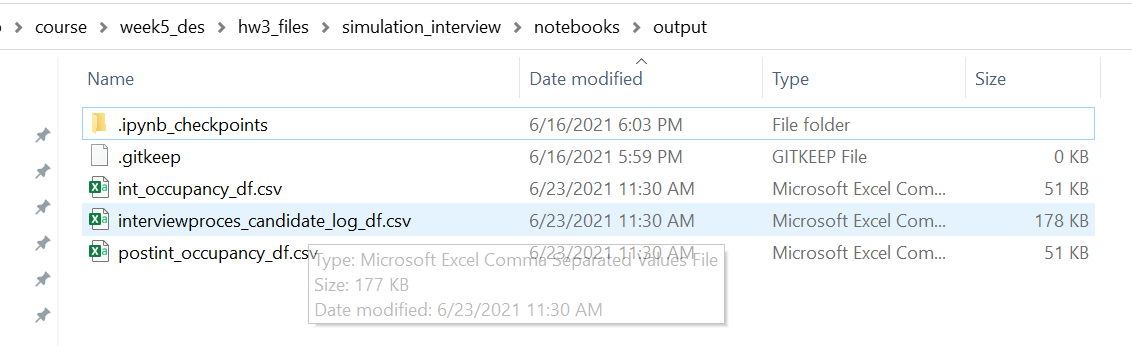

In [211]:
Image("images/results1.jpg")

#### Reading the file

In [212]:
interviewproces_candidate_log_df = pd.read_csv('./output/interviewproces_candidate_log_df.csv')
interviewproces_candidate_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   candidate_id                1066 non-null   int64  
 1   arrival_ts                  1066 non-null   float64
 2   got_reg_ts                  1066 non-null   float64
 3   release_reg_ts              1066 non-null   float64
 4   got_screening_staff_ts      1066 non-null   float64
 5   release_screening_staff_ts  1066 non-null   float64
 6   got_interviewer_ts          1066 non-null   float64
 7   release_interviewer_ts      1066 non-null   float64
 8   got_scheduler_ts            553 non-null    float64
 9   release_scheduler_ts        553 non-null    float64
 10  exit_system_ts              1066 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 91.7 KB


In [213]:
interviewproces_candidate_log_df.head(10)

,candidate_id,arrival_ts,got_reg_ts,release_reg_ts,got_screening_staff_ts,release_screening_staff_ts,got_interviewer_ts,release_interviewer_ts,got_scheduler_ts,release_scheduler_ts,exit_system_ts
0,2,0.286,0.286,0.377,0.377,2.666,2.666,17.006,17.006,17.324,27.022
1,3,0.409,0.409,0.563,0.563,2.402,2.402,16.731,NaN,NaN,27.094
2,1,0.239,0.239,0.491,0.491,2.332,2.332,18.524,NaN,NaN,28.873
3,5,2.480,2.480,3.289,3.289,5.666,5.666,20.375,20.375,21.623,30.403
4,4,2.124,2.124,2.489,2.489,5.255,5.255,20.419,NaN,NaN,30.986
5,6,2.784,2.784,3.061,3.061,5.475,5.475,22.236,NaN,NaN,32.491
6,7,2.985,3.061,4.593,5.475,7.971,7.971,22.490,NaN,NaN,32.536
7,9,3.584,3.584,4.904,5.666,8.031,8.031,21.542,21.542,22.556,32.867
8,8,3.137,3.289,3.323,5.255,7.685,7.685,22.713,NaN,NaN,33.032
9,12,4.817,4.995,7.234,7.971,9.680,9.680,24.219,24.219,25.137,34.327


created function compute_durations to calculate the waittimes between each process and the time required to complete each process

In [214]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_reg'] = timestamp_df.loc[:, 'got_reg_ts'] - timestamp_df.loc[:, 'arrival_ts']
    timestamp_df['wait_for_screening_staff'] = timestamp_df.loc[:, 'got_screening_staff_ts'] - timestamp_df.loc[:, 'release_reg_ts']
    timestamp_df['wait_for_interviewer'] = timestamp_df.loc[:, 'got_interviewer_ts'] - timestamp_df.loc[:, 'release_screening_staff_ts']
    timestamp_df['interview_time'] = timestamp_df.loc[:, 'release_interviewer_ts'] - timestamp_df.loc[:, 'got_interviewer_ts']
    timestamp_df['wait_for_scheduler'] = timestamp_df.loc[:, 'got_scheduler_ts'] - timestamp_df.loc[:, 'release_interviewer_ts']
    timestamp_df['post_int_time'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'release_interviewer_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'arrival_ts']
    
    return timestamp_df

In [215]:
interviewproces_candidate_log_df = compute_durations(interviewproces_candidate_log_df)

interviewproces_candidate_log_df

,candidate_id,arrival_ts,got_reg_ts,release_reg_ts,got_screening_staff_ts,release_screening_staff_ts,got_interviewer_ts,release_interviewer_ts,got_scheduler_ts,release_scheduler_ts,exit_system_ts,wait_for_reg,wait_for_screening_staff,wait_for_interviewer,interview_time,wait_for_scheduler,post_int_time,time_in_system
0,2,0.286,0.286,0.377,0.377,2.666,2.666,17.006,17.006,17.324,27.022,0.000,0.000,0.000,14.340,0.0,10.016,26.736
1,3,0.409,0.409,0.563,0.563,2.402,2.402,16.731,NaN,NaN,27.094,0.000,0.000,0.000,14.329,NaN,10.362,26.685
2,1,0.239,0.239,0.491,0.491,2.332,2.332,18.524,NaN,NaN,28.873,0.000,0.000,0.000,16.192,NaN,10.348,28.634
3,5,2.480,2.480,3.289,3.289,5.666,5.666,20.375,20.375,21.623,30.403,0.000,0.000,0.000,14.708,0.0,10.028,27.924
4,4,2.124,2.124,2.489,2.489,5.255,5.255,20.419,NaN,NaN,30.986,0.000,0.000,0.000,15.164,NaN,10.566,28.861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1065,419.810,537.712,538.720,706.152,707.155,1324.260,1339.959,1339.959,1340.855,1350.991,117.902,167.433,617.106,15.698,0.0,11.032,931.181
1062,1060,418.904,533.697,534.214,703.895,705.839,1322.924,1339.154,NaN,NaN,1351.345,114.792,169.681,617.085,16.230,NaN,12.190,932.440
1063,1063,419.268,536.443,540.080,707.666,709.125,1327.580,1341.184,NaN,NaN,1351.439,117.175,167.586,618.455,13.604,NaN,10.255,932.171
1064,1064,419.775,537.227,537.712,705.839,707.666,1324.837,1340.764,NaN,NaN,1352.039,117.451,168.127,617.171,15.927,NaN,11.275,932.264


In [216]:
interviewproces_candidate_log_df.loc[:, ['wait_for_reg', 'wait_for_screening_staff','wait_for_interviewer', 'wait_for_scheduler', 'time_in_system']].describe()

,wait_for_reg,wait_for_screening_staff,wait_for_interviewer,wait_for_scheduler,time_in_system
count,1066.000,1066.000,1066.000,553.000,1066.000
mean,59.301,82.167,307.238,0.013,477.180
std,32.131,51.157,179.701,0.077,262.570
min,0.000,0.000,0.000,0.000,26.685
25%,38.163,32.681,151.221,0.000,250.363
50%,62.262,80.173,303.619,0.000,476.352
75%,85.105,125.703,464.257,0.000,705.040
max,118.547,171.285,618.455,0.824,933.328


From the table above we can see that the average wait time for an interviewer and screening staff is pretty high .We should look at increasing the number of interviewers and screening staff in the facility.

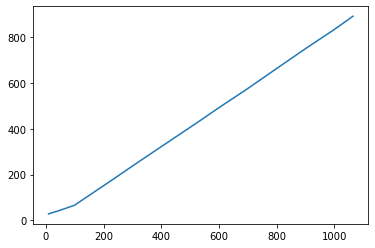

In [217]:
y = interviewproces_candidate_log_df['time_in_system'].rolling(100, 10).mean()
plt.plot(y)

From the graph above we understand that average total time in system is increasing very fast which confirms that more resources are required to complete the interview process effeciently.

Utilization of resources - As we understand that wait times are high for interviewers and screening staff we will calculate their utilization.

In [218]:
num_interviewers = 12
available_capacity_int = interview_end_time * num_interviewers
print(available_capacity_int)

16242.004012048521


In [219]:
used_capacity_int = interviewproces_candidate_log_df['interview_time'].sum()
interviewer_utilization = used_capacity_int/available_capacity_int
print(f"Interviewer utilization :{interviewer_utilization:0.3f}")

Interviewer utilization :0.983


Interviewer utilization is pretty high which ultimately increases the time a candidate is spending in the system. 

For this model we had hard coded the values of number of resources which will make the process tedious if we want to alter various other parameters.

#### Improved Model

So the best option is too create a .py file which will import needed parameters from a configuration file and publish the results as required. So I have created a .py file `interview_simulation_model` which will accept parameters from the configuration files.Once the files are generated as csv files the same can be imported into a datframe and data can be analysed as required.

Once we run the .py file we csv files get saved in the output folder. We can alter different configuration files to get the best numbrt of resources required for the interview facility.

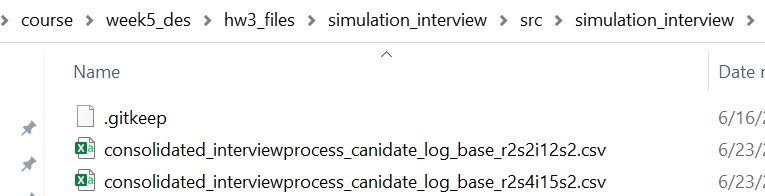

In [220]:
Image("images/results2.jpg")

In [221]:
interviewproces_candidate_log_df_base_r2s2i12s2 = pd.read_csv('../src/simulation_interview/output/consolidated_interviewprocess_canidate_log_base_r2s2i12s2.csv')
interviewproces_candidate_log_df_base_r2s2i12s2.head()

,scenario,rep_num,candidate_id,arrival_ts,got_reg_ts,release_reg_ts,got_screening_staff_ts,release_screening_staff_ts,got_interviewer_ts,release_interviewer_ts,got_scheduler_ts,release_scheduler_ts,exit_system_ts,wait_for_reg,wait_for_screening_staff,wait_for_interviewer,interview_time,wait_for_scheduler,post_int_time,time_in_system
0,base_r2s2i12s2,1,2,0.238,0.238,0.330,0.330,2.618,2.618,16.958,NaN,NaN,32.175,0.000,0.000,0.0,14.340,NaN,15.217,31.937
1,base_r2s2i12s2,1,3,0.341,0.341,0.495,2.292,4.361,4.361,18.999,18.999,19.978,34.084,0.000,1.797,0.0,14.638,0.0,15.085,33.743
2,base_r2s2i12s2,1,4,1.770,1.770,2.660,2.660,4.504,4.504,17.332,17.332,18.295,34.587,0.000,0.000,0.0,12.828,0.0,17.256,32.817
3,base_r2s2i12s2,1,5,2.046,2.046,3.676,4.504,6.319,6.319,20.456,NaN,NaN,35.812,0.000,0.828,0.0,14.138,NaN,15.356,33.767
4,base_r2s2i12s2,1,6,2.167,2.660,2.936,4.361,5.746,5.746,20.774,NaN,NaN,35.949,0.492,1.424,0.0,15.028,NaN,15.176,33.782


In [222]:
interviewproces_candidate_log_df_base_r2s2i12s2['wait_for_interviewer'].mean()

226.16180474744735

The wait time for interviewer can be reduced by adding more resorces to the process.

Imported the object from interview_simulation_model.py file

In [223]:
from simulation_interview import simulate, process_sim_output

Added arguments as required

reg_staff: 2
screening_staff: 2
interviewers: 12
schedulers: 2

In [224]:
args = {'candidate_arrival_rate': 180,
        'num_reg_staff': 2,
        'num_screening_staff': 2,
        'num_interviewers': 12,
        'num_schedulers': 2,
        'scenario': 'base_r2s2i12s2',
        'pct_second_round': 0.50,
        'reg_time_mean': 1.0,
        'document_check_time_mean': 2.0,
        'document_check_time_sd': 0.5,
        'interview_time_mean': 15.0,
        'interview_time_sd': 1.0,
        'sched_time_mean': 1.00,
        'sched_time_sd': 0.10,
        'post_int_time': 15.0,
        'add_post_int_time_mean': 1.0,
        'stoptime': 600,
        'num_reps': 2,
        'seed': 123,
        'output_path': 'output',
        'quiet': True}

# Pull out key variable values for convenience
num_reps = args['num_reps']
scenario = args['scenario']

# Set the output directory
if len(args['output_path']) > 0:
    output_dir = Path.cwd() / args['output_path']
else:
    output_dir = Path.cwd()

# Run the simulation for the desired number of replications
for i in range(1, num_reps + 1):
    simulate(args, i)

# Consolidate the candidate logs and compute summary stats
candidate_log_stats = process_sim_output(output_dir, scenario)

# Print out summary statistics
print(f"\nScenario: {scenario}")
pd.set_option("display.precision", 3)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print(candidate_log_stats['candidate_log_ci'])
print(candidate_log_stats['candidate_log_rep_stats'])

1811 candidates processed.
Simulation replication 1 ended at time 2294.678002660398
1842 candidates processed.
Simulation replication 2 ended at time 2332.70314061807

Scenario: base_r2s2i12s2
             wait_for_reg  wait_for_screening_staff  wait_for_interviewer  wait_for_scheduler  time_in_system
n_samples           2.000                     2.000                 2.000               2.000           2.000
mean_mean         145.550                   467.174               226.174               0.024         872.833
sd_mean            21.132                    13.247                 2.056               0.011           5.887
ci_95_lower       116.263                   448.815               223.324               0.009         864.674
ci_95_upper       174.838                   485.532               229.024               0.038         880.992
{'wait_for_reg':           count     mean     std  min     25%      50%      75%      max
rep_num                                                  

Increased screenstaff to 4 and interviewers to 20
reg_staff: 2
screening_staff: 4
interviewers: 20
schedulers: 2

In [225]:
args = {'candidate_arrival_rate': 180,
        'num_reg_staff': 2,
        'num_screening_staff': 4,
        'num_interviewers': 20,
        'num_schedulers': 2,
        'scenario': 'base_r2s4i20s2',
        'pct_second_round': 0.50,
        'reg_time_mean': 1.0,
        'document_check_time_mean': 2.0,
        'document_check_time_sd': 0.5,
        'interview_time_mean': 15.0,
        'interview_time_sd': 1.0,
        'sched_time_mean': 1.00,
        'sched_time_sd': 0.10,
        'post_int_time': 15.0,
        'add_post_int_time_mean': 1.0,
        'stoptime': 600,
        'num_reps': 2,
        'seed': 123,
        'output_path': 'output',
        'quiet': True}

# Pull out key variable values for convenience
num_reps = args['num_reps']
scenario = args['scenario']

# Set the output directory
if len(args['output_path']) > 0:
    output_dir = Path.cwd() / args['output_path']
else:
    output_dir = Path.cwd()

# Run the simulation for the desired number of replications
for i in range(1, num_reps + 1):
    simulate(args, i)

# Consolidate the candidate logs and compute summary stats
candidate_log_stats = process_sim_output(output_dir, scenario)

# Print out summary statistics
print(f"\nScenario: {scenario}")
pd.set_option("display.precision", 3)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print(candidate_log_stats['candidate_log_ci'])
print(candidate_log_stats['candidate_log_rep_stats'])

1830 candidates processed.
Simulation replication 1 ended at time 1404.3471611038058
1842 candidates processed.
Simulation replication 2 ended at time 1419.0516837105768

Scenario: base_r2s4i20s2
             wait_for_reg  wait_for_screening_staff  wait_for_interviewer  wait_for_scheduler  time_in_system
n_samples           2.000                     2.000                 2.000           2.000e+00           2.000
mean_mean         153.297                    11.553               220.011           5.727e-02         418.880
sd_mean            20.250                     6.997                 2.512           9.697e-04          10.825
ci_95_lower       125.232                     1.856               216.529           5.592e-02         403.878
ci_95_upper       181.363                    21.251               223.492           5.861e-02         433.883
{'wait_for_reg':           count     mean     std  min     25%      50%      75%      max
rep_num                                               

Increased registration staff to 3 and interviewers to 25
reg_staff: 3
screening_staff: 4
interviewers: 18
schedulers: 2

In [226]:
args = {'candidate_arrival_rate': 180,
        'num_reg_staff': 3,
        'num_screening_staff': 4,
        'num_interviewers': 25,
        'num_schedulers': 2,
        'scenario': 'base_r3s4i18s2',
        'pct_second_round': 0.50,
        'reg_time_mean': 1.0,
        'document_check_time_mean': 2.0,
        'document_check_time_sd': 0.5,
        'interview_time_mean': 15.0,
        'interview_time_sd': 1.0,
        'sched_time_mean': 1.00,
        'sched_time_sd': 0.10,
        'post_int_time': 15.0,
        'add_post_int_time_mean': 1.0,
        'stoptime': 600,
        'num_reps': 2,
        'seed': 123,
        'output_path': 'output',
        'quiet': True}

# Pull out key variable values for convenience
num_reps = args['num_reps']
scenario = args['scenario']

# Set the output directory
if len(args['output_path']) > 0:
    output_dir = Path.cwd() / args['output_path']
else:
    output_dir = Path.cwd()

# Run the simulation for the desired number of replications
for i in range(1, num_reps + 1):
    simulate(args, i)

# Consolidate the candidate logs and compute summary stats
candidate_log_stats = process_sim_output(output_dir, scenario)

# Print out summary statistics
print(f"\nScenario: {scenario}")
pd.set_option("display.precision", 3)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print(candidate_log_stats['candidate_log_ci'])
print(candidate_log_stats['candidate_log_rep_stats'])

1786 candidates processed.
Simulation replication 1 ended at time 1104.2521887702508
1790 candidates processed.
Simulation replication 2 ended at time 1109.2086302350087

Scenario: base_r3s4i18s2
             wait_for_reg  wait_for_screening_staff  wait_for_interviewer  wait_for_scheduler  time_in_system
n_samples           2.000                     2.000                 2.000               2.000           2.000
mean_mean          12.298                   140.906                83.640               0.100         270.860
sd_mean             9.580                     9.853                 1.217               0.034           0.944
ci_95_lower        -0.980                   127.251                81.953               0.054         269.552
ci_95_upper        25.576                   154.561                85.326               0.147         272.169
{'wait_for_reg':           count    mean    std  min    25%     50%     75%     max
rep_num                                                     

On comparing above tables we see that as we increase the resources wait time in each of the process will decrease. The data in the csv files in output folder can be imported to dataframes and can be anlyzed further.

Creating a .py file and then importing it to jupyterlab will help us in working with data in an effecient manner.

### Conclusion

In this simulation project I have created different versions of interview simulation starting with a simple model to a model in which we can import parameters in a configuration file. Simulation models help us predicting the requirements for any process smoothly and efficiently.